<a href="https://colab.research.google.com/github/LeehyeongTea/show-and-tell/blob/main/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


sq a white dog running through the snow eq
 sq a white dog runs through the snow eq


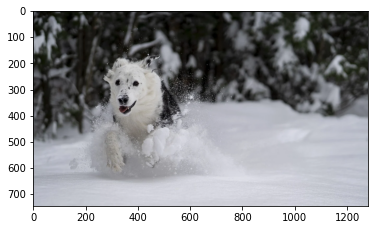

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import h5py
import re

from nltk.translate.bleu_score import corpus_bleu
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import pickle

from matplotlib.pyplot import imshow
from PIL import Image
def create_caption_greedy(model, tokenizer, feature, max_len):
  start = 'sq'
  for i in range(max_len):
    seq = tokenizer.texts_to_sequences([start])[0]
    seq = pad_sequences([seq],maxlen = max_len)

    pred = model.predict([feature, seq],verbose = 0)
    
    pred = np.argmax(pred)
    pred_word = 'eq'

    for word, i in tokenizer.word_index.items():
      if i == pred:
        pred_word = word

    start = start + ' '+ pred_word
    if pred_word == 'eq':
      break
  return start



def create_caption_beam(model, tokenizer, feature, max_len, k):
  start = 'sq'
  start = tokenizer.texts_to_sequences([start])[0]
  depth_seq=[]
  for word, num in tokenizer.word_index.items():
    if word == 'eq':
      end = num
  #end일때 더이상 따지지 않기 위해 end를 찾아놓음
  sequences = [[start, 0.0]]
  max_len_flag=list()
  end_flag =0

  depth_seq=[]
  while len(sequences[0][0]) < max_len :
    all_candidate = list()
    depth =1
    for sequence in sequences:
      seq = pad_sequences([sequence[0]],maxlen = max_len)
      

      all_pred = model.predict([feature, seq],verbose = 0)

      candidate_preds = np.argsort(all_pred[0])[-k:]

      for candidate in candidate_preds: 
        get_cap = sequence[0][:]
        score = sequence[1]
        get_cap.append(candidate)
        score = score+np.log(all_pred[0][candidate]+1e-10)
        if get_cap[-1] == end :
          #depth만큼 나눠 평균을 구해준다.
          depth_seq.append([get_cap,score/depth])
          continue
        else :  
          all_candidate.append([get_cap,score])
    sequences = all_candidate
    
    
    sequences = sorted(sequences, key = lambda I: I[1])
    sequences = sequences[-k:]

  depth_seq = sorted(depth_seq, key = lambda l: l[1])
  #print(depth_seq)
  depth_seq = depth_seq[-1][0]
  #print(depth_seq)
  #최고점수 시퀀스 찾음
  
  text = ''
  
  for t in depth_seq:
    for word,i in tokenizer.word_index.items():
      if i==t:
        if word != 'eq' or word != 'sq':
          text = text+' '+word
        elif word == 'eq':
          break

  return text

  
def preprocessing_image(trained_model,img_file,tokenizer,max_len):
  get_CNN = InceptionV3()
  CNN_model = Model(inputs=get_CNN.input, outputs=get_CNN.layers[-2].output)
  loaded_img = Image.open(img_file, 'r')
  imshow(np.asarray(loaded_img))
  loaded_img = image.load_img(img_file, target_size = (299, 299))
  loaded_img = image.img_to_array(loaded_img)
  loaded_img = preprocess_input(loaded_img)
  loaded_img = np.expand_dims(loaded_img, 0)
  feature = CNN_model.predict(loaded_img)
  
  print(create_caption_greedy(trained_model, tokenizer, feature, max_len))
  print(create_caption_beam(trained_model, tokenizer, feature, max_len, 3))


if __name__ == '__main__':
  
  
  base_path = '/content/gdrive/My Drive/Colab Notebooks/showandtell/merge update/inference'
  data_h5_paths = os.path.join(base_path,'needs.hdf5')
  needs = h5py.File(data_h5_paths, 'r')
  
  
  max_len = needs['max_len'][()]
  vocab_size= needs['vocab_size'][()]
  
  
  model_path = os.path.join(base_path,'model_39_vacc_0.372_vloss_3.722_acc0.538_loss2.069.h5')
  
  trained_model = load_model(model_path)

  img_file = os.path.join(base_path,'example1.jpg')

  req_token_path = os.path.join(base_path, 'token.pickle')
  with open(req_token_path, 'rb') as handle:
    tokenizer = pickle.load(handle)
 
  preprocessing_image(trained_model,img_file,tokenizer,max_len)